In [351]:
import numpy as np
import pandas as pd

In [352]:
df = pd.DataFrame()
df['X1'] = [1,2,3,4,5,6,6,7,9,9]
df['X2'] = [5,3,6,8,1,9,5,8,9,2]
df['label'] = [1,1,0,1,0,1,0,1,0,0]
df

,X1,X2,label
0,1,5,1
1,2,3,1
2,3,6,0
3,4,8,1
4,5,1,0
5,6,9,1
6,6,5,0
7,7,8,1
8,9,9,0
9,9,2,0


<Axes: xlabel='X1', ylabel='X2'>

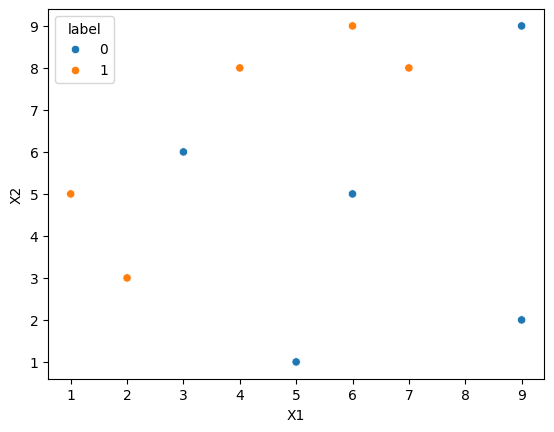

In [353]:
import seaborn as sns
sns.scatterplot(x=df['X1'], y=df['X2'], hue=df['label'])

# AdaBoost

In [354]:
df['weights'] = 1/df.shape[0]
df

,X1,X2,label,weights
0,1,5,1,0.1
1,2,3,1,0.1
2,3,6,0,0.1
3,4,8,1,0.1
4,5,1,0,0.1
5,6,9,1,0.1
6,6,5,0,0.1
7,7,8,1,0.1
8,9,9,0,0.1
9,9,2,0,0.1


In [355]:
X = df.iloc[:,0:2].values
y = df.iloc[:,2].values

1st Decision Stump

[Text(0.5, 0.75, 'x[0] <= 2.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(0.625, 0.5, '  False')]

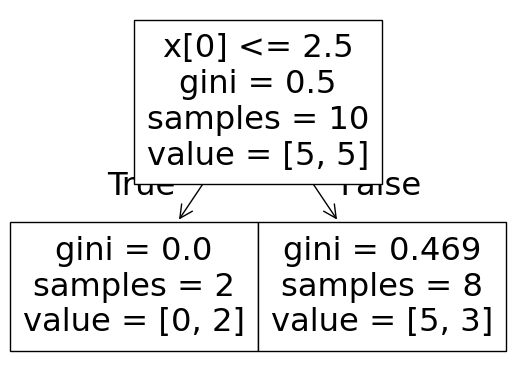

In [356]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(X,y)
plot_tree(dt1)

<Axes: >

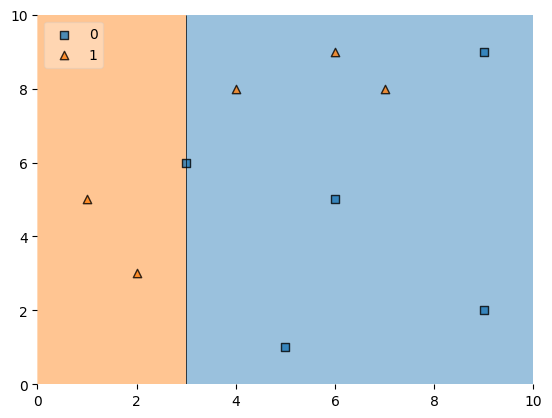

In [357]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X,y,clf=dt1,legend=2)

In [358]:
df['y_pred'] = dt1.predict(X)
df

,X1,X2,label,weights,y_pred
0,1,5,1,0.1,1
1,2,3,1,0.1,1
2,3,6,0,0.1,0
3,4,8,1,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,0
6,6,5,0,0.1,0
7,7,8,1,0.1,0
8,9,9,0,0.1,0
9,9,2,0,0.1,0


Calculate weight for the 1st Decision Stump

In [359]:
def calculate_model_weight(error):
  return 0.5*np.log((1-error)/error)

In [360]:
mask = df['label'] != df['y_pred']
error=np.round((df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha1 = calculate_model_weight(error)
alpha1

0.3


np.float64(0.42364893019360184)

Update row weights

In [361]:
def update_row_weights(row, alpha):
  if row['label'] == row['y_pred']:
    return row['weights'] * np.exp(-alpha)
  else:
    return row['weights'] * np.exp(alpha)

In [362]:
df['updated_weights'] = df.apply(update_row_weights,axis=1, args=(alpha1,))     # axis =1 means applying function to each row
df

,X1,X2,label,weights,y_pred,updated_weights
0,1,5,1,0.1,1,0.065465
1,2,3,1,0.1,1,0.065465
2,3,6,0,0.1,0,0.065465
3,4,8,1,0.1,0,0.152753
4,5,1,0,0.1,0,0.065465
5,6,9,1,0.1,0,0.152753
6,6,5,0,0.1,0,0.065465
7,7,8,1,0.1,0,0.152753
8,9,9,0,0.1,0,0.065465
9,9,2,0,0.1,0,0.065465


Normalizing updated_weights

In [363]:
df['normalized_weights'] = df['updated_weights'] / df['updated_weights'].sum()
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights
0,1,5,1,0.1,1,0.065465,0.071429
1,2,3,1,0.1,1,0.065465,0.071429
2,3,6,0,0.1,0,0.065465,0.071429
3,4,8,1,0.1,0,0.152753,0.166667
4,5,1,0,0.1,0,0.065465,0.071429
5,6,9,1,0.1,0,0.152753,0.166667
6,6,5,0,0.1,0,0.065465,0.071429
7,7,8,1,0.1,0,0.152753,0.166667
8,9,9,0,0.1,0,0.065465,0.071429
9,9,2,0,0.1,0,0.065465,0.071429


Making range

In [364]:
df['cumsum_upper'] = np.cumsum(df['normalized_weights'])
df['cumsum_lower'] = df['cumsum_upper'] - df['normalized_weights'] 
df = df[['X1','X2','label','weights','y_pred','updated_weights','normalized_weights','cumsum_lower','cumsum_upper']]
df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_lower,cumsum_upper
0,1,5,1,0.1,1,0.065465,0.071429,0.000000,0.071429
1,2,3,1,0.1,1,0.065465,0.071429,0.071429,0.142857
2,3,6,0,0.1,0,0.065465,0.071429,0.142857,0.214286
3,4,8,1,0.1,0,0.152753,0.166667,0.214286,0.380952
4,5,1,0,0.1,0,0.065465,0.071429,0.380952,0.452381
5,6,9,1,0.1,0,0.152753,0.166667,0.452381,0.619048
6,6,5,0,0.1,0,0.065465,0.071429,0.619048,0.690476
7,7,8,1,0.1,0,0.152753,0.166667,0.690476,0.857143
8,9,9,0,0.1,0,0.065465,0.071429,0.857143,0.928571
9,9,2,0,0.1,0,0.065465,0.071429,0.928571,1.000000


Creating new dataset for 2nd Decision Stump

In [365]:
def create_new_dataset(df):
  indices = []
  
  for i in range(df.shape[0]):
    a = np.random.random()
    for index,row in df.iterrows():
      if row['cumsum_upper'] > a and a > row['cumsum_lower']:
        indices.append(index)

  return indices

In [366]:
index_values = create_new_dataset(df)
index_values

[5, 9, 4, 2, 4, 5, 7, 4, 0, 5]

In [367]:
second_df = df.iloc[index_values , [0,1,2,3]]#.sort_index()
second_df

,X1,X2,label,weights
5,6,9,1,0.1
9,9,2,0,0.1
4,5,1,0,0.1
2,3,6,0,0.1
4,5,1,0,0.1
5,6,9,1,0.1
7,7,8,1,0.1
4,5,1,0,0.1
0,1,5,1,0.1
5,6,9,1,0.1


2nd Decision Stump

[Text(0.5, 0.75, 'x[1] <= 3.5\ngini = 0.5\nsamples = 10\nvalue = [5, 5]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]'),
 Text(0.625, 0.5, '  False')]

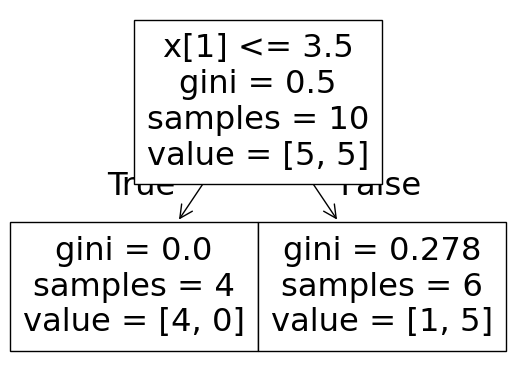

In [368]:
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt2 = DecisionTreeClassifier(max_depth=1)
dt2.fit(X,y)
plot_tree(dt2)

<Axes: >

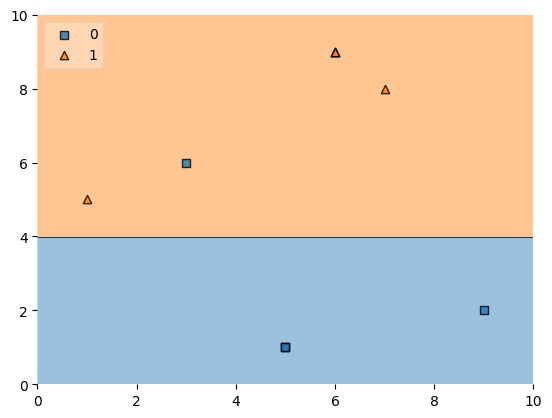

In [369]:
plot_decision_regions(X,y,clf=dt2 , legend =2)

In [370]:
second_df['y_pred'] = dt2.predict(X)
second_df

,X1,X2,label,weights,y_pred
5,6,9,1,0.1,1
9,9,2,0,0.1,0
4,5,1,0,0.1,0
2,3,6,0,0.1,1
4,5,1,0,0.1,0
5,6,9,1,0.1,1
7,7,8,1,0.1,1
4,5,1,0,0.1,0
0,1,5,1,0.1,1
5,6,9,1,0.1,1


In [371]:
mask = second_df['label'] != second_df['y_pred']
error=np.round((second_df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha2 = calculate_model_weight(error)
alpha2

0.1


np.float64(1.0986122886681098)

In [372]:
second_df['updated_weights'] = df.apply(update_row_weights,axis=1, args=(alpha2,))
second_df

,X1,X2,label,weights,y_pred,updated_weights
5,6,9,1,0.1,1,0.300000
9,9,2,0,0.1,0,0.033333
4,5,1,0,0.1,0,0.033333
2,3,6,0,0.1,1,0.033333
4,5,1,0,0.1,0,0.033333
5,6,9,1,0.1,1,0.300000
7,7,8,1,0.1,1,0.300000
4,5,1,0,0.1,0,0.033333
0,1,5,1,0.1,1,0.033333
5,6,9,1,0.1,1,0.300000


In [373]:
second_df['normalized_weights'] = second_df['updated_weights'] / second_df['updated_weights'].sum()
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights
5,6,9,1,0.1,1,0.300000,0.214286
9,9,2,0,0.1,0,0.033333,0.023810
4,5,1,0,0.1,0,0.033333,0.023810
2,3,6,0,0.1,1,0.033333,0.023810
4,5,1,0,0.1,0,0.033333,0.023810
5,6,9,1,0.1,1,0.300000,0.214286
7,7,8,1,0.1,1,0.300000,0.214286
4,5,1,0,0.1,0,0.033333,0.023810
0,1,5,1,0.1,1,0.033333,0.023810
5,6,9,1,0.1,1,0.300000,0.214286


In [374]:
second_df['normalized_weights'].sum()

np.float64(1.0)

In [375]:
second_df['cumsum_upper'] = np.cumsum(second_df['normalized_weights'])
second_df['cumsum_lower'] = second_df['cumsum_upper'] - second_df['normalized_weights'] 
second_df = second_df[['X1','X2','label','weights','y_pred','updated_weights','normalized_weights','cumsum_lower','cumsum_upper']]
second_df

,X1,X2,label,weights,y_pred,updated_weights,normalized_weights,cumsum_lower,cumsum_upper
5,6,9,1,0.1,1,0.300000,0.214286,0.000000,0.214286
9,9,2,0,0.1,0,0.033333,0.023810,0.214286,0.238095
4,5,1,0,0.1,0,0.033333,0.023810,0.238095,0.261905
2,3,6,0,0.1,1,0.033333,0.023810,0.261905,0.285714
4,5,1,0,0.1,0,0.033333,0.023810,0.285714,0.309524
5,6,9,1,0.1,1,0.300000,0.214286,0.309524,0.523810
7,7,8,1,0.1,1,0.300000,0.214286,0.523810,0.738095
4,5,1,0,0.1,0,0.033333,0.023810,0.738095,0.761905
0,1,5,1,0.1,1,0.033333,0.023810,0.761905,0.785714
5,6,9,1,0.1,1,0.300000,0.214286,0.785714,1.000000


In [376]:
index_values = create_new_dataset(second_df)
index_values

[5, 2, 4, 5, 5, 5, 5, 5, 5, 5]

In [377]:
third_df = second_df.iloc[index_values , [0,1,2,3]]
third_df

,X1,X2,label,weights
5,6,9,1,0.1
4,5,1,0,0.1
4,5,1,0,0.1
5,6,9,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1
5,6,9,1,0.1


3rd Decision Stump

In [378]:
X = second_df.iloc[:,0:2].values
y = second_df.iloc[:,2].values

dt3 = DecisionTreeClassifier(max_depth=1)
dt3.fit(X,y)


DecisionTreeClassifier(max_depth=1)

<Axes: >

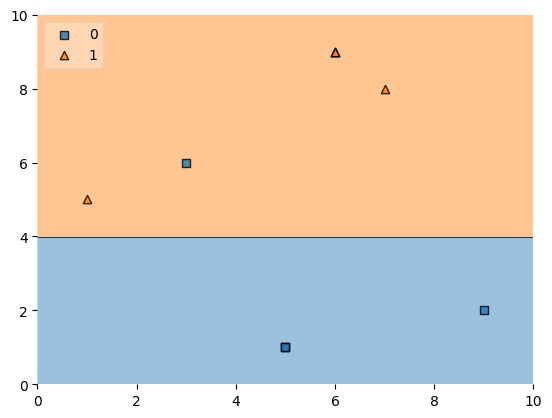

In [379]:
plot_decision_regions(X, y, clf=dt3, legend=2)


In [380]:
third_df['y_pred'] = dt3.predict(X)
third_df


,X1,X2,label,weights,y_pred
5,6,9,1,0.1,1
4,5,1,0,0.1,0
4,5,1,0,0.1,0
5,6,9,1,0.1,1
5,6,9,1,0.1,0
5,6,9,1,0.1,1
5,6,9,1,0.1,1
5,6,9,1,0.1,0
5,6,9,1,0.1,1
5,6,9,1,0.1,1


In [381]:
mask = second_df['label'] != second_df['y_pred']
error=np.round((second_df.loc[mask,'weights'].sum()) , 5)
print(error)
alpha3 = calculate_model_weight(error)
alpha3

0.1


np.float64(1.0986122886681098)

# Prediction

In [382]:
print(alpha1,alpha2,alpha3)


0.42364893019360184 1.0986122886681098 1.0986122886681098


In [383]:
query = np.array([1,5]).reshape(1,2)
dt1.predict(query)

array([1])

In [384]:
dt2.predict(query)


array([1])

In [385]:
dt3.predict(query)


array([1])

In [394]:
alpha1*1 + alpha2*(1) + alpha3*(1)


np.float64(2.6208735075298213)

In [395]:
np.sign(2.6208735075298213)


np.float64(1.0)

In [396]:
query = np.array([9,9]).reshape(1,2)
dt1.predict(query)

array([0])

In [397]:
dt2.predict(query)


array([1])

In [398]:
dt3.predict(query)


array([1])

In [399]:
alpha1*(-1) + alpha2*(1) + alpha3*(1)


np.float64(1.7735756471426178)

In [400]:
np.sign(1.7735756471426178)


np.float64(1.0)